In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [4]:
df = pd.read_csv("wine-reviews.csv", usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])

In [5]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [6]:
df = df.dropna(subset=["description", "points"])

In [7]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


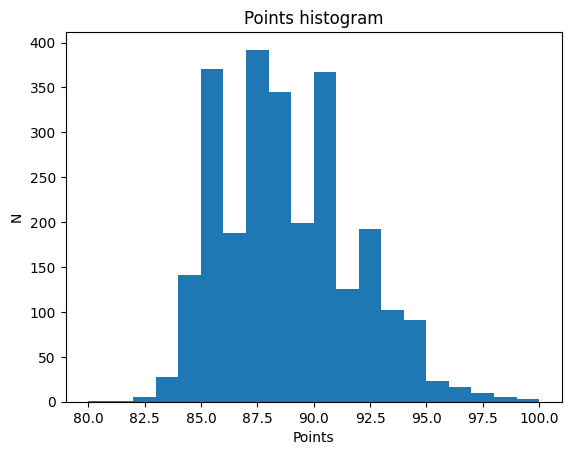

In [8]:
plt.hist(df.points, bins=20)
plt.title("Points histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [9]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [10]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [11]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [12]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# Embedding + Model

In [13]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [14]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.35375655, -0.24626346, -0.06702651, ..., -0.10808578,
        -0.12919809, -0.01798842],
       [ 0.17504106, -0.22560398, -0.05761321, ...,  0.20166174,
         0.18637343, -0.22008418],
       [ 0.48658356, -0.16161932, -0.21863075, ..., -0.19164157,
         0.06932908,  0.34922305],
       ...,
       [ 0.54631335, -0.18388185,  0.07796745, ..., -0.13986424,
        -0.15324368, -0.06242161],
       [ 0.33438885, -0.29797596,  0.12562913, ..., -0.09961262,
        -0.08076888,  0.29970217],
       [ 0.13207433, -0.13192284, -0.09428792, ..., -0.01257708,
        -0.03478488,  0.0908204 ]], dtype=float32)>

In [15]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [17]:
model.evaluate(train_data)

3/3 [==============================] - 1s 12ms/step - loss: 0.7285 - accuracy: 0.3546


[0.7284632325172424, 0.3546065390110016]

In [18]:
model.evaluate(valid_data)

1/1 [==============================] - 0s 21ms/step - loss: 0.7231 - accuracy: 0.3870


[0.7230530381202698, 0.38697317242622375]

In [19]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
3/3 [==============================] - 5s 1s/step - loss: 0.7285 - accuracy: 0.4141 - val_loss: 0.7075 - val_accuracy: 0.4253
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 0.7092 - accuracy: 0.4573 - val_loss: 0.6971 - val_accuracy: 0.4828
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 0.6991 - accuracy: 0.4976 - val_loss: 0.6897 - val_accuracy: 0.5517
Epoch 4/5
3/3 [==============================] - 4s 1s/step - loss: 0.6857 - accuracy: 0.5561 - val_loss: 0.6841 - val_accuracy: 0.5824
Epoch 5/5
3/3 [==============================] - 4s 1s/step - loss: 0.6802 - accuracy: 0.5979 - val_loss: 0.6797 - val_accuracy: 0.5977


In [20]:
model.evaluate(test_data)

1/1 [==============================] - 0s 173ms/step - loss: 0.6755 - accuracy: 0.6322


[0.6754900813102722, 0.6321839094161987]

# LSTM

In [21]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [22]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'of', 'a', 'with', 'this', 'is', 'wine',
       'in', 'flavors', 'it', 'to', 'fruit', 'its', 'on', 'aromas',
       'palate', 'that'], dtype='<U17')

In [23]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [25]:
model.evaluate(train_data)
model.evaluate(valid_data)

1/1 [==============================] - 0s 43ms/step - loss: 0.6933 - accuracy: 0.4866


[0.693300724029541, 0.48659002780914307]

In [26]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
3/3 [==============================] - 7s 439ms/step - loss: 0.6926 - accuracy: 0.5417 - val_loss: 0.6901 - val_accuracy: 0.6092
Epoch 2/5
3/3 [==============================] - 1s 311ms/step - loss: 0.6883 - accuracy: 0.6468 - val_loss: 0.6864 - val_accuracy: 0.6092
Epoch 3/5
3/3 [==============================] - 1s 255ms/step - loss: 0.6832 - accuracy: 0.6464 - val_loss: 0.6817 - val_accuracy: 0.6092
Epoch 4/5
3/3 [==============================] - 1s 256ms/step - loss: 0.6767 - accuracy: 0.6464 - val_loss: 0.6761 - val_accuracy: 0.6092
Epoch 5/5
3/3 [==============================] - 1s 235ms/step - loss: 0.6683 - accuracy: 0.6464 - val_loss: 0.6699 - val_accuracy: 0.6092


In [27]:
model.evaluate(test_data)

1/1 [==============================] - 0s 50ms/step - loss: 0.6644 - accuracy: 0.6322


[0.66439288854599, 0.6321839094161987]